# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle.

Another option: just take the data from [drive](https://drive.google.com/drive/folders/17CYgXfOHr-4aHlcOVbhKojjjPyD84dMu?usp=sharing) :)

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print(f'PyTorch version: {torch.__version__}')

PyTorch version: 1.6.0+cu101


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparing Training and Test Sets

In [22]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'drive/My Drive/COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [17]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        self.image_dirs = image_dirs
        self.transform = transform

        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images

        for class_name in self.class_names:
                self.images[class_name] = get_images(class_name)


    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [18]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),  # cause resnet is pretrained for this size
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std = [0.229, 0.224, 0.225])
    
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),  # cause resnet is pretrained for this size
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std = [0.229, 0.224, 0.225])
    
])

# Prepare DataLoader

In [24]:
train_dirs = {
    'normal': 'drive/My Drive/COVID-19 Radiography Database/normal',
    'viral': 'drive/My Drive//COVID-19 Radiography Database/viral',
    'covid': 'drive/My Drive//COVID-19 Radiography Database/covid'
}


train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [23]:
test_dirs = {
    'normal': 'drive/My Drive//COVID-19 Radiography Database/test/normal',
    'viral': 'drive/My Drive//COVID-19 Radiography Database/test/viral',
    'covid': 'drive/My Drive//COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)


Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [25]:
batch_size=6
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f'Num of training batches: {len(dl_train)}, num of test batches: {len(dl_test)}')

Num of training batches: 470, num of test batches: 15


# Data Visualization

In [26]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(2, 3, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

Checking the plot function, obviously, all predictions will be correct :)

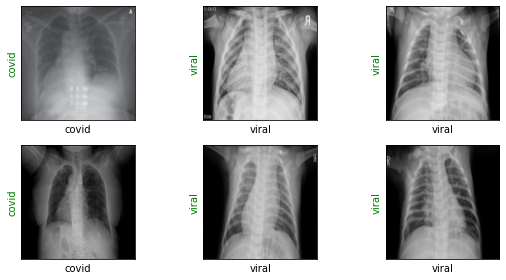

In [27]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

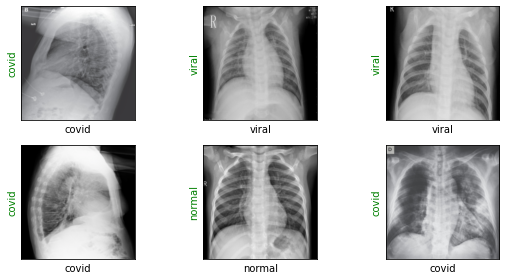

In [28]:
# and the test set
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Downloading the Model

In [29]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
# should be fixed

# from graphviz import Digraph
# import re
# import torch
# import torch.nn.functional as F
# from torch.autograd import Variable
# from torch.autograd import Variable
# import torchvision.models as models


# def make_dot(var):
#     node_attr = dict(style='filled',
#                      shape='box',
#                      align='left',
#                      fontsize='12',
#                      ranksep='0.1',
#                      height='0.2')
#     dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
#     seen = set()

#     def add_nodes(var):
#         if var not in seen:
#             if isinstance(var, Variable):
#                 value = '('+(', ').join(['%d'% v for v in var.size()])+')'
#                 dot.node(str(id(var)), str(value), fillcolor='lightblue')
#             else:
#                 dot.node(str(id(var)), str(type(var).__name__))
#             seen.add(var)
#             if hasattr(var, 'previous_functions'):
#                 for u in var.previous_functions:
#                     dot.edge(str(id(u[0])), str(id(var)))
#                     add_nodes(u[0])
#     add_nodes(var.creator)
#     return dot


# inputs = torch.randn(1,3,224,224)
# resnet18_1 = torchvision.models.resnet18()
# y = resnet18_1(Variable(inputs))
# # print(y)

# g = make_dot(y)
# g.view()

In [33]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features=3)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

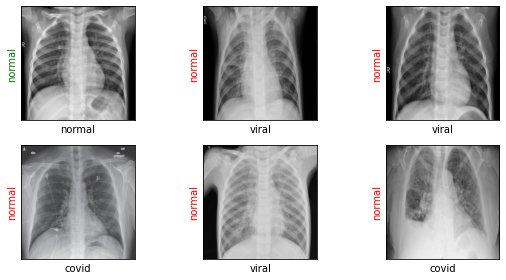

In [34]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    vals, preds = torch.max(outputs, 1) 
    show_images(images, labels, preds)
#     print(vals)
#     print(preds)
    
show_preds()

Okay, not so good since it's not trained on our data yet

# Training the Model

In [35]:
accuracy_thresh = 0.95

def train(epochs):
    print('Training...')
    for e in range(0, epochs):
        print('_'*20)
        print(f'epoch {e + 1} out of {epochs}')
        print('_'*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() 

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() 

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= accuracy_thresh:
                    print(f'accuracy reached {accuracy_thresh}, stopping training')
                    return 

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('done')

Training...
____________________
epoch 1 out of 5
____________________
evaluating at step 0
Validation Loss: 1.5467, Accuracy: 0.2889


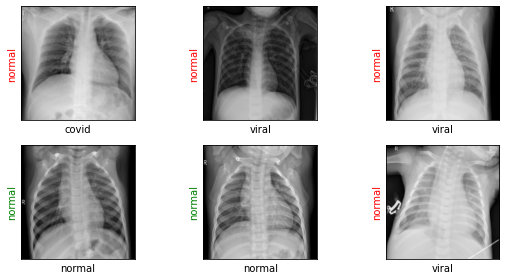

evaluating at step 20
Validation Loss: 0.9404, Accuracy: 0.6222


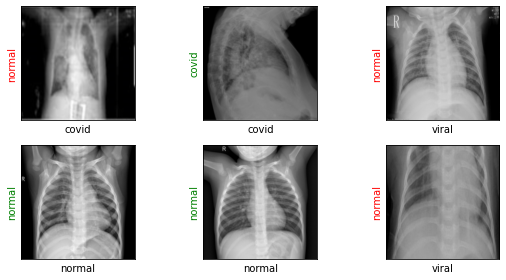

evaluating at step 40
Validation Loss: 0.5677, Accuracy: 0.8111


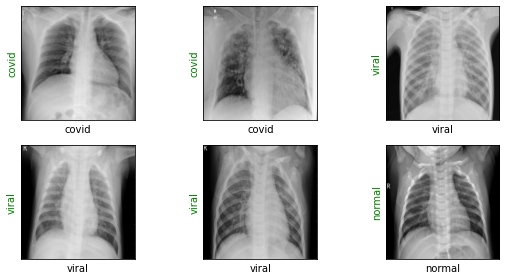

evaluating at step 60
Validation Loss: 0.3163, Accuracy: 0.9111


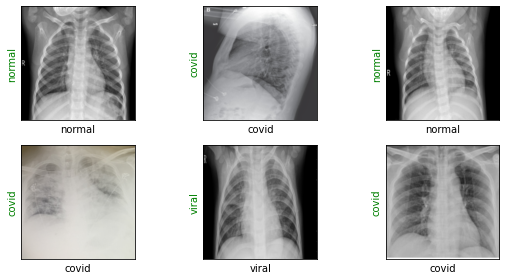

evaluating at step 80
Validation Loss: 0.2475, Accuracy: 0.9111


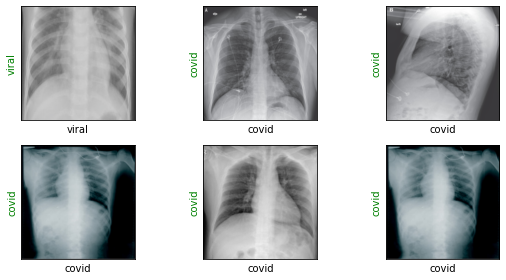

evaluating at step 100
Validation Loss: 0.1106, Accuracy: 1.0000


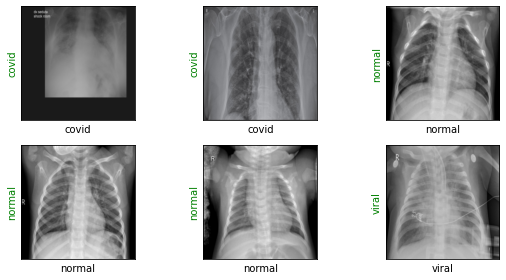

accuracy reached 0.95, stopping training


In [36]:
train(epochs=5)

# Final Results

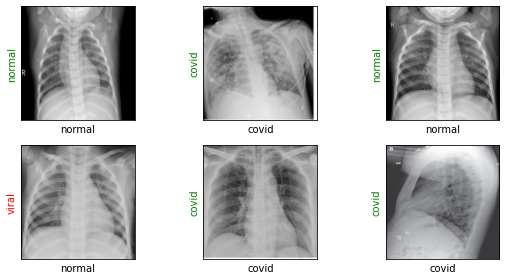

In [38]:
show_preds()